In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [26]:
image_width = 450
image_height = 600
batch = 16
channels = 3
train_size = 0.8
test_size = 0.1
epochs = 20

Creating datasets for leaf images and plant images

In [31]:
leafs_dataset = tf.keras.preprocessing.image_dataset_from_directory("D:\Medicinal Plant Identification\Indian Medicinal Leaves Image Datasets\Smaller Leaf dataset", shuffle=True, image_size=(image_width,image_height), batch_size=batch)

Found 809 files belonging to 8 classes.


In [4]:
# plants_dataset = tf.keras.preprocessing.image_dataset_from_directory("D:\Medicinal Plant Identification\Indian Medicinal Leaves Image Datasets\Medicinal plant dataset", shuffle=True, image_size=(image_width,image_height), batch_size=batch)

In [32]:
leafs_classes= leafs_dataset.class_names
# plant_classes = plants_dataset.class_names
leafs_classes

['Aloevera',
 'Amla',
 'Bamboo',
 'Insulin',
 'Mint',
 'Tulsi',
 'Turmeric',
 'camphor']

(16, 450, 600, 3)
[4 0 2 2 5 4 1 3 5 5 4 5 0 5 1 5]


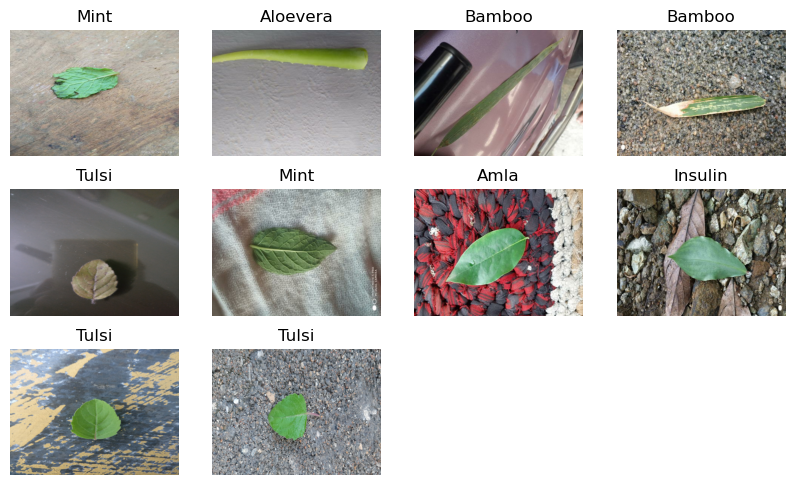

In [33]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in leafs_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range (10):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(leafs_classes[labels_batch[i]])
        plt.axis('off')

In [34]:
print(len(leafs_dataset)*train_size)
print(len(leafs_dataset)*test_size)

40.800000000000004
5.1000000000000005


In [8]:
# leafs_train_dataset = leafs_dataset.take(172)

In [9]:
# leafs_test_dataset = leafs_dataset.skip(172)
# len(leafs_test_dataset)

In [10]:
# leafs_val_dataset = leafs_test_dataset.take(21)
# leafs_test_dataset = leafs_test_dataset.skip(21)

In [36]:
def get_dataset(ds, train_split=0.7, val_split=0.15, test_split = 0.1, shuffle=True, shuffle_size=100):
  #assert(train_split+val_split+test_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12) 

  train_size = int(train_split*ds_size)
  valid_size = int(val_split*ds_size)
  leafs_train_dataset = ds.take(train_size)
  leafs_val_dataset = ds.skip(train_size).take(valid_size)
  leafs_test_dataset = ds.skip(train_size).skip(valid_size)
  
  return leafs_train_dataset, leafs_val_dataset, leafs_test_dataset

In [37]:
train_ds, val_ds, test_ds = get_dataset(leafs_dataset)

In [38]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


35
7
9


In [39]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 450, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(image_width,image_height)
])

In [43]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [52]:
input_shape = (batch, image_width,image_height,channels)
n_classes = 8
model = models.Sequential([
    resize_and_rescale,
    data_aug,
    #convolutional layers
    layers.Conv2D(16, kernel_size=(3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    #flattening layers
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [53]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 450, 600, 3)       0         
                                                                 
 sequential_7 (Sequential)   (16, 450, 600, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (16, 448, 598, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (16, 224, 299, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (16, 222, 297, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (16, 111, 148, 32)        0         
 g2D)                                                

In [54]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [55]:
history = model.fit(
    train_ds,
    batch_size = batch,
    validation_data = val_ds,
    verbose = 1,
    epochs = epochs
)

Epoch 1/20
35/35 [==============================] - 144s 4s/step - loss: 3.2713 - accuracy: 0.1844 - val_loss: 2.0369 - val_accuracy: 0.3238
Epoch 2/20
35/35 [==============================] - 131s 4s/step - loss: 1.8471 - accuracy: 0.3074 - val_loss: 1.5054 - val_accuracy: 0.4821
Epoch 3/20
35/35 [==============================] - 137s 4s/step - loss: 1.7062 - accuracy: 0.3643 - val_loss: 1.7002 - val_accuracy: 0.3143
Epoch 4/20
35/35 [==============================] - 147s 4s/step - loss: 1.6457 - accuracy: 0.3893 - val_loss: 1.5153 - val_accuracy: 0.4107
Epoch 5/20
35/35 [==============================] - 147s 4s/step - loss: 1.5824 - accuracy: 0.4141 - val_loss: 1.5774 - val_accuracy: 0.4375
Epoch 6/20
35/35 [==============================] - 141s 4s/step - loss: 1.5644 - accuracy: 0.4071 - val_loss: 1.5056 - val_accuracy: 0.4286
Epoch 7/20
35/35 [==============================] - 133s 4s/step - loss: 1.5273 - accuracy: 0.4231 - val_loss: 1.5646 - val_accuracy: 0.4107
Epoch 8/20
35

In [56]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 15s 601ms/step - loss: 0.8668 - accuracy: 0.7153


In [57]:
scores


[0.8667628169059753, 0.7152777910232544]